<a href="https://colab.research.google.com/github/mking2014/final-4449-king/blob/main/age_binning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook Overview

### Purpose
Notebook builds model for predicting a persons age. The following techniques were tested
- Balancing dataset (oversampling & undersampling)
- Regression model to predict continuous age
- Multi-classification model to predict 'age bins' for unbalanced, and both 'flavors' of balanced datasets
  - Age bins
    - Child: 0 - 12
    - Teenager: 12 - 20
    - Young Adult: 20 - 35
    - Adult: 35 - 50
    - Senior: 50 - 75
    - Elderly: 75+

### Results

Model's 3 & 4 are performing best
- Model 3
  - Trained on unbalanced dataset
  - Has higher accuracy overall
- Model 4
  - Trained on oversampled dataset
  - Has lower overally accuracy, but is better at picking out some classes i.e. teenager
  - Majority of wrong predictions are in neighboring class i.e. Adult is categorized as a young adult

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input, RandomFlip, RandomRotation, RandomContrast, BatchNormalization
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from math import sqrt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Connection to google colab drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

Gender: Male = 0, Female = 1


In [3]:
df = pd.read_csv('/content/drive/MyDrive/comp4449_final/data/age_gender.csv')
df = df.drop(columns = ['img_name'])
print(f"Dataset size: {df.shape}")
df.head()

Dataset size: (23705, 4)


,age,ethnicity,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,202 205 209 210 209 209 210 211 212 214 218 21...


In [4]:
# Converting pixels into numpy array
df['pixels']=df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

# EDA

Text(0, 0.5, 'Count')

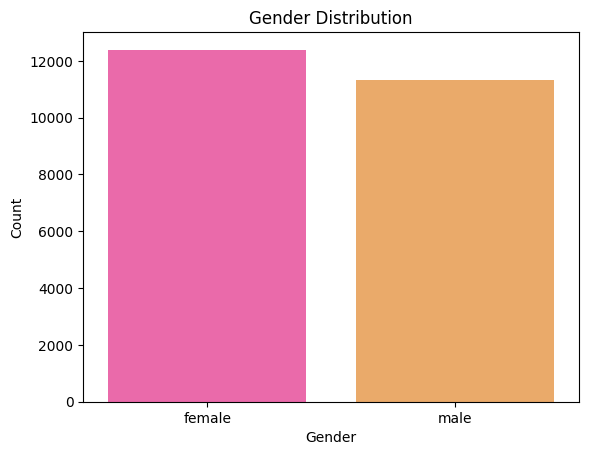

In [8]:
sns.countplot(x="gender", palette='spring', data=df.replace({"gender" : {1 : "male", 0 : "female"}}))
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

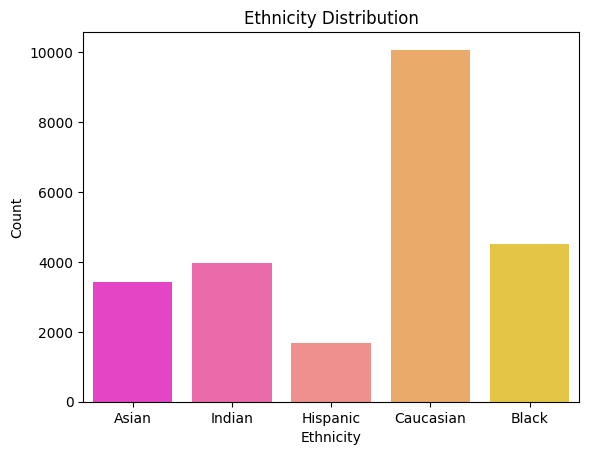

In [9]:
sns.countplot(x="ethnicity", palette='spring',
              data=df.replace({"ethnicity" : {0: "Caucasian", 1: "Black", 2: "Asian", 3:"Indian", 4:"Hispanic"}}))

plt.title('Ethnicity Distribution')
plt.xlabel('Ethnicity')
plt.ylabel('Count')

Text(0.5, 0, 'Age')

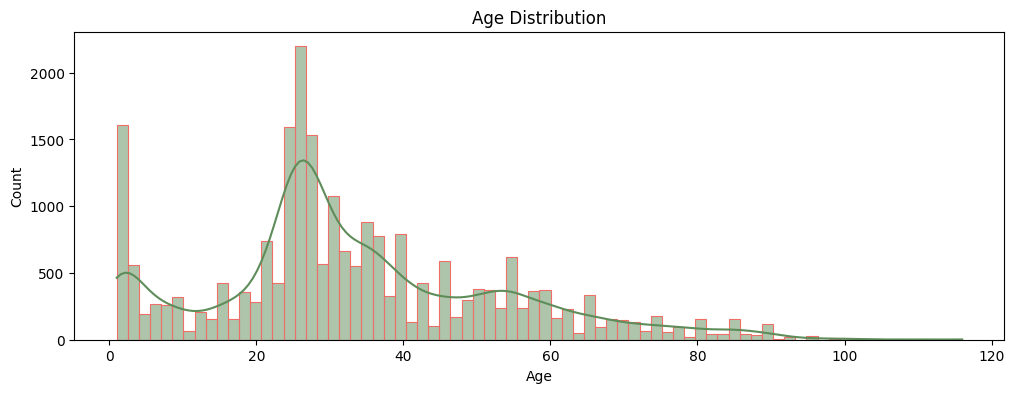

In [10]:
plt.figure(figsize=(12, 4))

sns.histplot(data = df, x='age', color = '#5e8d5a', edgecolor='#ee6f68', kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')

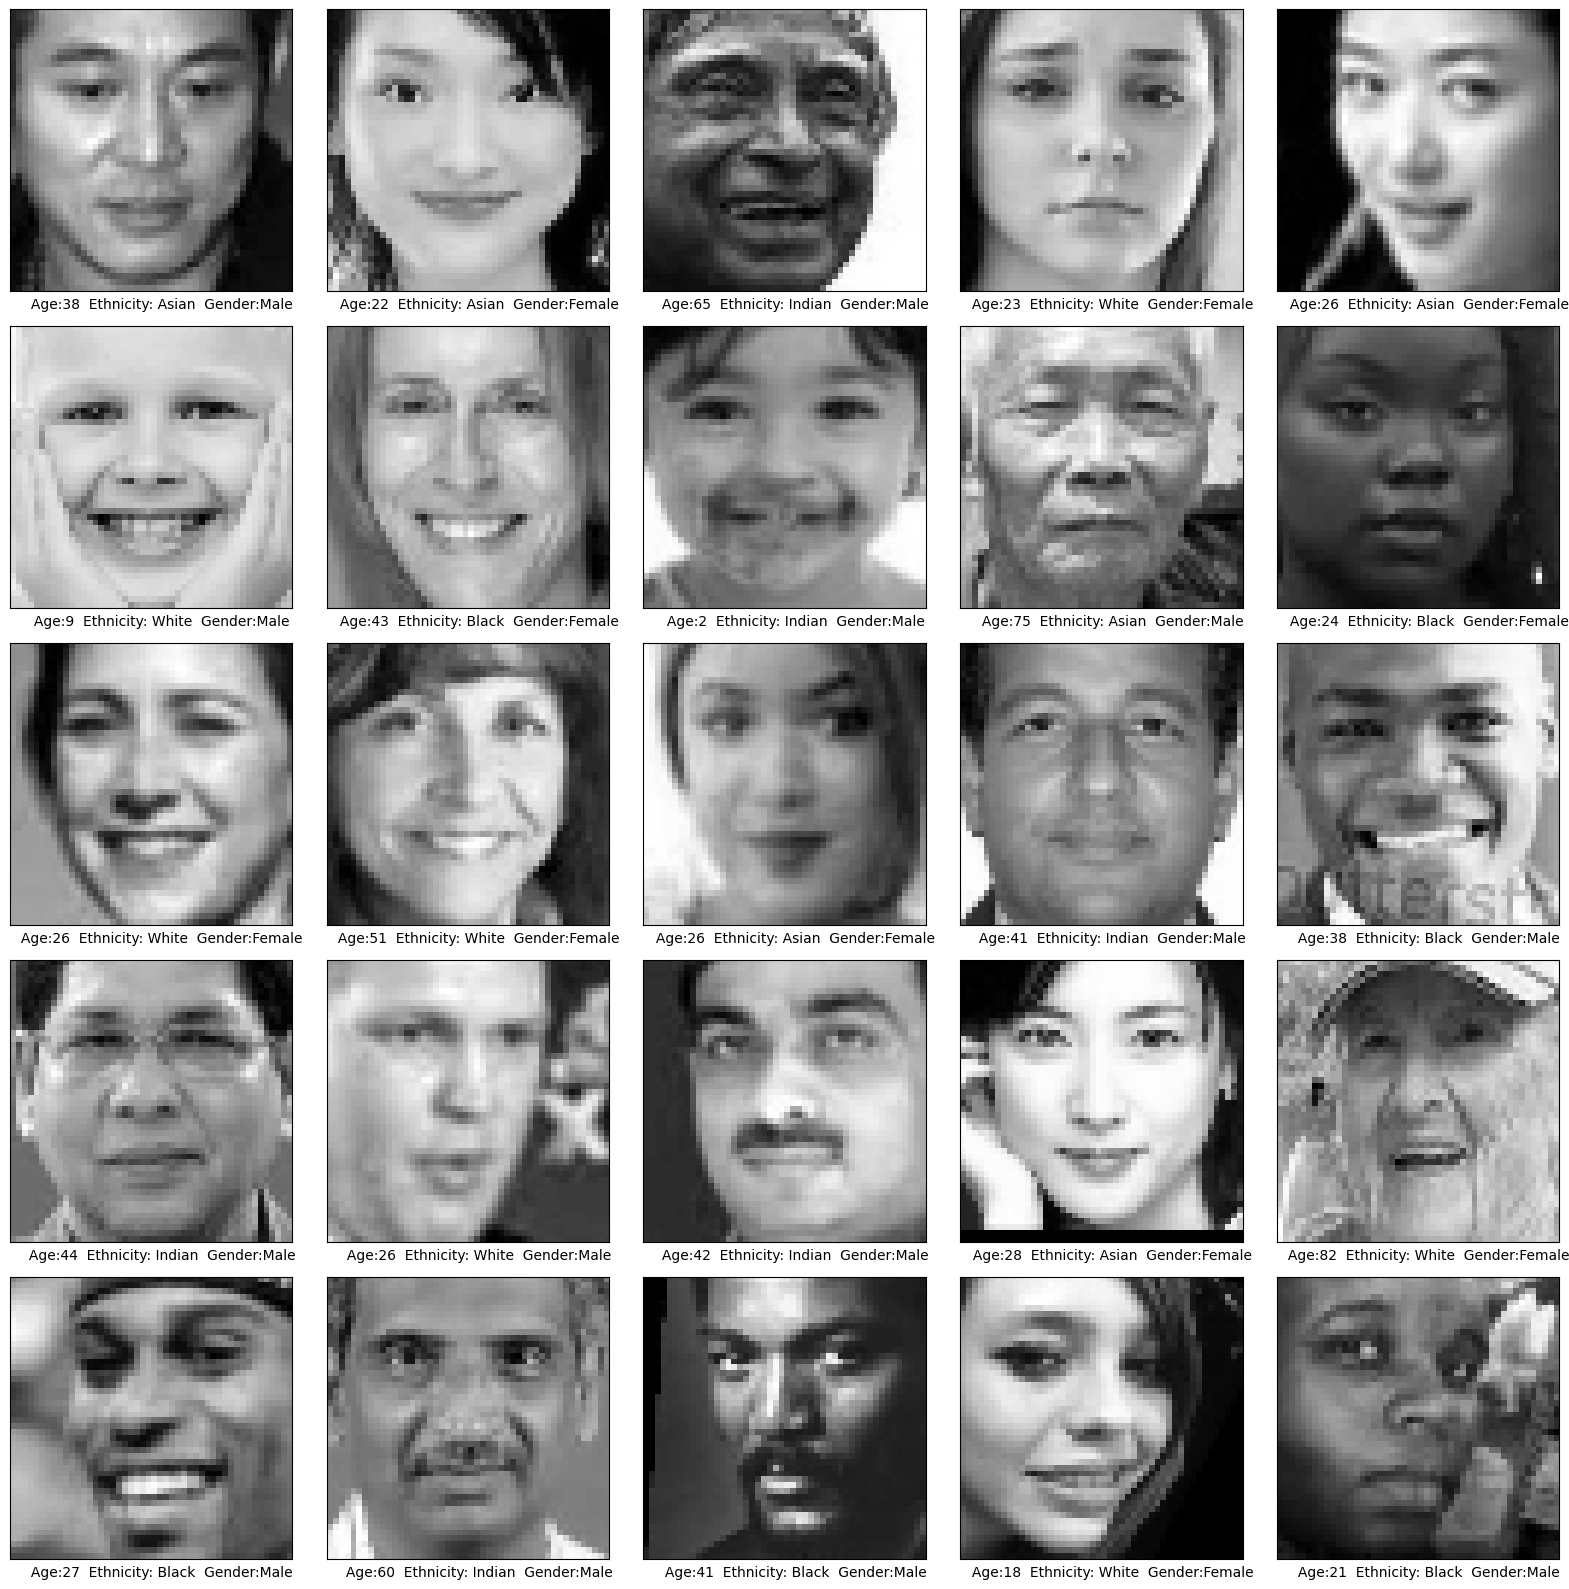

In [11]:
ethnicity_list = ["White", "Black", "Asian", "Indian", "Hispanic"]
gender_list = ['Male', 'Female']

plt.figure(figsize=(16,16))

for i,a in zip(np.random.randint(0, 23705, 25),range(1,26)):
    plt.subplot(5,5,a)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df['pixels'].iloc[i].reshape(48, 48), cmap ='gray')
    plt.xlabel(
        "     Age:"+str(df['age'].iloc[i])+
        "  Ethnicity: "+ str(ethnicity_list[df['ethnicity'].iloc[i]])+
        "  Gender:"+ str(gender_list[df['gender'].iloc[i]])
    )

plt.tight_layout()
plt.show()

# Data Preparation
Data was 'binned' in preperation for classification model. Balanced datasets were also created by both oversampling and undersampling



In [6]:
df.head()

,age,ethnicity,gender,pixels
0,1,2,0,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


<Axes: xlabel='age_bin', ylabel='count'>

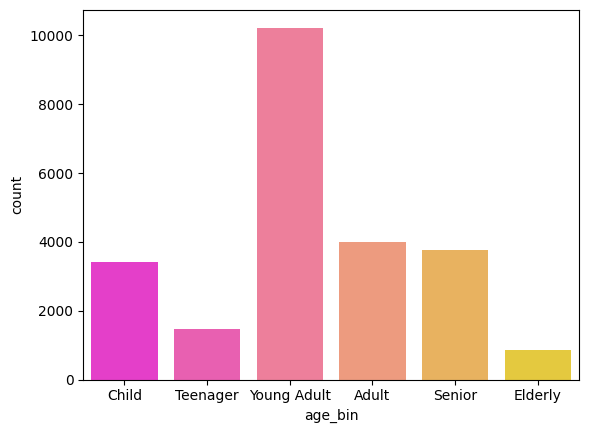

In [7]:
bins = [0, 12, 20, 35, 50, 75, 116]
labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior', 'Elderly']
df['age_bin'] = pd.cut(x = df['age'], bins = bins, labels = labels, include_lowest = True)
df['age_bin'].value_counts()

sns.countplot(data = df, x = 'age_bin', palette = 'spring')

In [8]:
# create label encoding for binning ages
encoder = LabelEncoder()
df['ages_encoded'] = encoder.fit_transform(df['age_bin'])
df.head()

age_mapping = dict(zip(range(len(encoder.classes_)), encoder.classes_ ))
age_mapping

{0: 'Adult',
 1: 'Child',
 2: 'Elderly',
 3: 'Senior',
 4: 'Teenager',
 5: 'Young Adult'}

In [9]:
test, train = train_test_split(df, test_size=0.85, random_state=42)
print(train.shape)
print(test.shape)

(20150, 6)
(3555, 6)


In [10]:
#Reshaping images in training & test datasets

X_train = train['pixels']
# normalizing pixels data
X_train = X_train/255.0

# reshape images
X_train = np.array(X_train.tolist())
X_train = X_train.reshape(-1,48,48, 1)
print(f"Shape of training images: {X_train.shape}")


X_test = test['pixels']
# normalizing pixels data
X_test = X_test/255.0

# reshape images
X_test = np.array(X_test.tolist())
X_test = X_test.reshape(-1,48,48, 1)
print(f"Shape of images: {X_test.shape}")

Shape of training images: (20150, 48, 48, 1)
Shape of images: (3555, 48, 48, 1)


In [11]:
# create y training datasets for age regression model

y_train_age = train['age']
y_train_gender = train['gender']
print(f"Age array shape: {(y_train_age.shape)}")
print(f"Gender array shape: {(y_train_gender.shape)}")

y_test_age = test['age']
y_test_gender = test['gender']
print(f"Age array shape: {(y_test_age.shape)}")
print(f"Gender array shape: {(y_test_gender.shape)}")

Age array shape: (20150,)
Gender array shape: (20150,)
Age array shape: (3555,)
Gender array shape: (3555,)


In [12]:
# create y training datasets for age binning model
y_train_age_binned = train['ages_encoded']
print(f"Age array shape: {(y_train_age_binned.shape)}")

y_test_age_binned = test['ages_encoded']
print(f"Age array shape: {(y_test_age_binned.shape)}")

Age array shape: (20150,)
Age array shape: (3555,)


In [13]:
input_shape = (48, 48, 1)
num_classes = len(set(y_train_age_binned))

####Creating blanced training dataset - oversampling

<Axes: xlabel='age_bin', ylabel='count'>

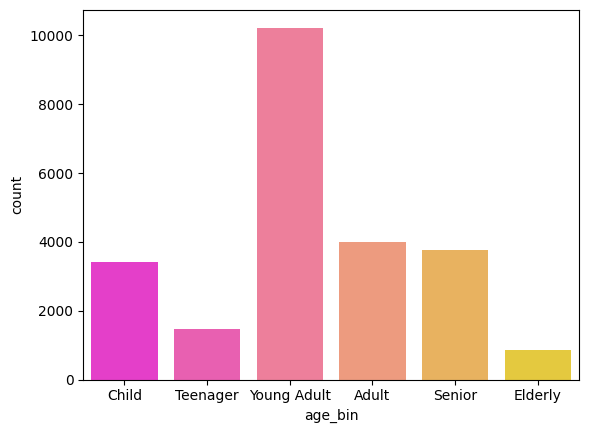

In [14]:
sns.countplot(data = df, x = 'age_bin', palette = 'spring')

In [17]:
X_train_balanced = train['pixels']
X_train_balanced = X_train_balanced/255.0

# reshape images
X_train_balanced = np.array(X_train_balanced.tolist())
# X_train_balanced = X_train_balanced.reshape(-1,48,48, 1)

y_train_balanced = train['ages_encoded']

In [18]:
ros = RandomOverSampler(random_state=27, sampling_strategy = {0:6000, 4: 6000, 2:4000})
X_train_over, y_train_over = ros.fit_resample(X_train_balanced, y_train_balanced)

In [19]:
X_train_over = X_train_over.reshape(-1,48,48, 1)

Text(0.5, 1.0, 'Balanced Dataset - Over Sampling')

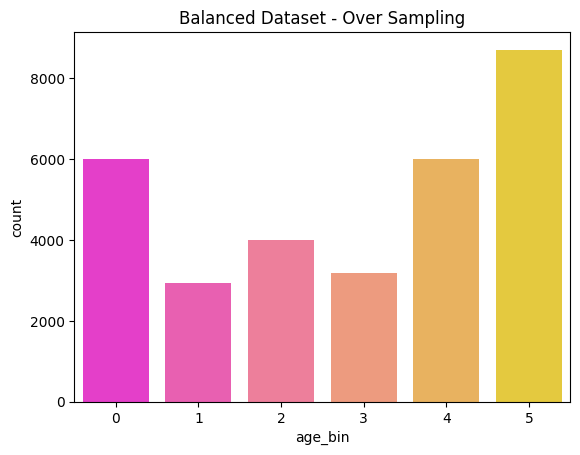

In [20]:
sns.countplot(data = pd.DataFrame({'age_bin':y_train_over}), x = 'age_bin', palette = 'spring')
plt.title('Balanced Dataset - Over Sampling')

In [21]:
print(f"Shape of images: {X_train_over.shape}")
print(f"Shape of balanced array: {y_train_over.shape}")

Shape of images: (30813, 48, 48, 1)
Shape of balanced array: (30813,)


####Creating blanced training dataset - undersampling

In [22]:
ros = RandomUnderSampler(random_state=27, sampling_strategy = {5:6000})
X_train_under, y_train_under = ros.fit_resample(X_train_balanced, y_train_balanced)

In [23]:
X_train_under = X_train_under.reshape(-1,48,48, 1)

Text(0.5, 1.0, 'Balanced Dataset - Under Sampling')

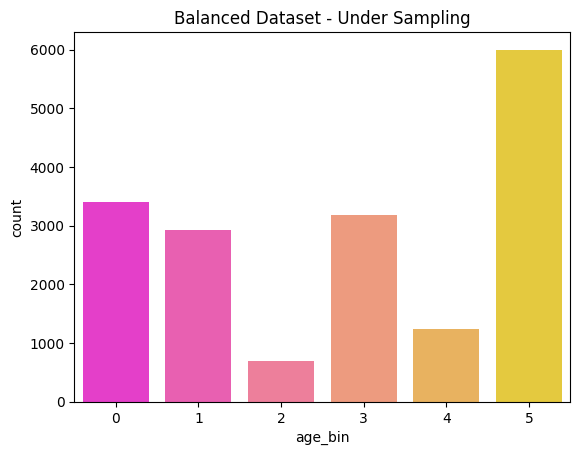

In [24]:
sns.countplot(data = pd.DataFrame({'age_bin':y_train_under}), x = 'age_bin', palette = 'spring')
plt.title('Balanced Dataset - Under Sampling')

In [25]:
print(f"Shape of images: {X_train_under.shape}")
print(f"Shape of balanced array: {y_train_under.shape}")

Shape of images: (17443, 48, 48, 1)
Shape of balanced array: (17443,)


# Model Developmnet

In [28]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input, RandomFlip, RandomRotation, RandomContrast, BatchNormalization
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from math import sqrt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report

### Age Model - Regression

In [34]:
def predict_age(label, img):
  print(f"Actual age: {label}")

  m_prediction = age_model.predict(img.reshape(-1,48,48, 1), verbose = 0)

  print(f"Predicted age: {m_prediction[0][0]}")

  return

In [35]:
age_model = Sequential([

    # convolutional layers
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = (input_shape)),
    MaxPooling2D(pool_size=(2, 2)),

    BatchNormalization(),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    BatchNormalization(),

    Flatten(),

    Dense(128, activation = 'relu'),
    Dropout(0.4),

    Dense(64, activation = 'relu'),
    Dropout(0.4),

    Dense(1, activation = 'relu')

])
age_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse', 'mae'])
age_model.build(input_shape)
age_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 23, 23, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                        

In [36]:
# Callbacks for age model
callbacks = [EarlyStopping(patience=4, monitor='val_loss', mode='min'),
             ReduceLROnPlateau(patience=2, verbose=1)]

In [37]:
history = age_model.fit(X_train, y_train_age,
                        epochs=30,
                        batch_size=32,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test_age))

Epoch 1/30
630/630 [==============================] - 18s 8ms/step - loss: 232.0769 - mse: 232.0769 - mae: 11.2030 - val_loss: 405.4940 - val_mse: 405.4940 - val_mae: 17.2893 - lr: 0.0010
Epoch 2/30
630/630 [==============================] - 4s 6ms/step - loss: 156.4830 - mse: 156.4830 - mae: 9.2056 - val_loss: 182.2432 - val_mse: 182.2432 - val_mae: 9.2957 - lr: 0.0010
Epoch 3/30
630/630 [==============================] - 4s 6ms/step - loss: 139.0224 - mse: 139.0224 - mae: 8.6465 - val_loss: 104.9422 - val_mse: 104.9422 - val_mae: 7.2176 - lr: 0.0010
Epoch 4/30
630/630 [==============================] - 5s 8ms/step - loss: 127.0605 - mse: 127.0605 - mae: 8.2418 - val_loss: 107.0942 - val_mse: 107.0942 - val_mae: 7.6669 - lr: 0.0010
Epoch 5/30
630/630 [==============================] - 4s 7ms/step - loss: 120.9222 - mse: 120.9222 - mae: 8.0516 - val_loss: 101.0276 - val_mse: 101.0276 - val_mae: 7.2245 - lr: 0.0010
Epoch 6/30
630/630 [==============================] - 4s 7ms/step - loss

#### Model Evaluation

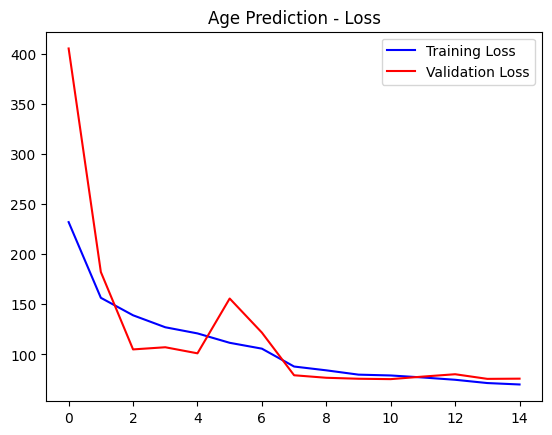

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Age Prediction - Loss')
plt.legend()
plt.show()

In [39]:
valid_score = age_model.evaluate(X_test, y_test_age, verbose=1)
valid_score

112/112 [==============================] - 0s 3ms/step - loss: 75.7261 - mse: 75.7261 - mae: 5.9683


[75.72610473632812, 75.72610473632812, 5.968334674835205]

In [40]:
y_pred_age = age_model.predict(X_test)

112/112 [==============================] - 0s 2ms/step


In [41]:
def evaluate_regression_model(a_labels, a_preds):
  plt.scatter(x = a_labels, y = a_preds)
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.title('Actual vs Predicted Ages')
  print(f"RMSE: {sqrt(mean_squared_error(a_labels, a_preds))}")
  print(f"MAE: {mean_absolute_error(a_labels, a_preds)}")
  return

RMSE: 8.702075054059025
MAE: 5.968334662126254


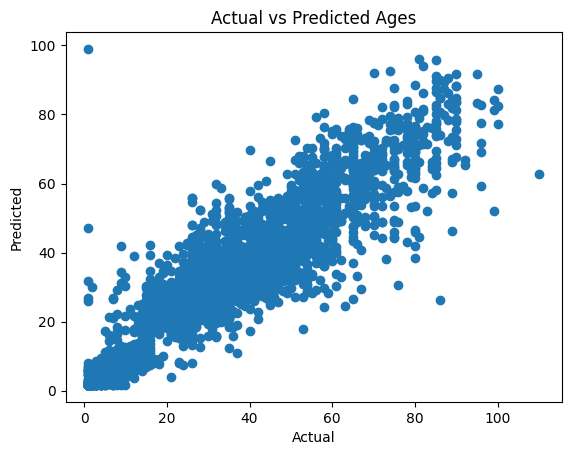

In [42]:
evaluate_regression_model(y_test_age, y_pred_age)

Best results for age model were not great considering the average age in the dataset is 30 years old!

In [43]:
pred = test.sample()
predict_age(pred.values[0][0], pred.values[0][3])

Actual age: 57
Predicted age: 326.0907287597656


### Age Model - Classification (binning ages)

In [36]:
def evaluate_classification_model(labels, preds, cm_labels):

  cm = confusion_matrix(labels, preds)
  sns.heatmap(cm, annot = True, fmt ='.0f', xticklabels=cm_labels, yticklabels=cm_labels)
  plt.ylabel('True Label')
  plt.xlabel('Predictied Label')
  plt.title('Age Bin Classficiation')
  # print(f"Accuracy: {accuracy_score(labels, preds)}")
  # print(f"Precision: {precision_score(labels, preds)}")
  # print(f"Recall: {recall_score(labels, preds)}")
  # print(f"F1 Score: {f1_score(labels, preds)}")
  print(classification_report(labels, preds, target_names = cm_labels))

  return

def predict_age(age, label, img):
  print(f"Actual age: {age}")
  print(f"Actual age group: {label}")

  m_prediction = age_model.predict(img.reshape(-1,48,48, 1), verbose = 0)

  print(f"Predicted age group: {age_mapping[np.argmax(m_prediction, axis = 1)[0]]}")

  return

#### Unbalanced Dataset

In [38]:
age_model = Sequential([

    RandomFlip(mode = 'horizontal', seed = 27, input_shape = (input_shape)),
    RandomFlip(mode = 'vertical', seed = 27),
    RandomRotation(factor = 0.1, fill_mode='nearest', seed = 27),
    RandomContrast(factor = 0.1, seed = 27),

    # convolutional layers
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = (input_shape)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(512, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dropout(0.2),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dropout(0.5),

    Dense(num_classes, activation = 'softmax')

])
age_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
age_model.build(input_shape)
age_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 48, 48, 1)         0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 48, 48, 1)         0         
                                                                 
 random_rotation_1 (RandomR  (None, 48, 48, 1)         0         
 otation)                                                        
                                                                 
 random_contrast_1 (RandomC  (None, 48, 48, 1)         0         
 ontrast)                                                        
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 23, 23, 32)       

In [39]:
logdir = os.path.join("logs/age_model", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [tensorboard_callback,
             EarlyStopping(patience=4, monitor='val_loss', mode='min'),
             ReduceLROnPlateau(patience=2, verbose=1, monitor='val_accuracy')]

#Fit on normal dataset
history = age_model.fit(X_train, y_train_age_binned,
                        epochs=50,
                        batch_size=32,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test_age_binned))



Epoch 1/50
630/630 [==============================] - 12s 14ms/step - loss: 1.5404 - accuracy: 0.4272 - val_loss: 1.4856 - val_accuracy: 0.4284 - lr: 0.0010
Epoch 2/50
630/630 [==============================] - 8s 12ms/step - loss: 1.4807 - accuracy: 0.4404 - val_loss: 1.4632 - val_accuracy: 0.4748 - lr: 0.0010
Epoch 3/50
630/630 [==============================] - 8s 12ms/step - loss: 1.4402 - accuracy: 0.4600 - val_loss: 1.3741 - val_accuracy: 0.5027 - lr: 0.0010
Epoch 4/50
630/630 [==============================] - 8s 12ms/step - loss: 1.3592 - accuracy: 0.4980 - val_loss: 1.2664 - val_accuracy: 0.5232 - lr: 0.0010
Epoch 5/50
630/630 [==============================] - 8s 12ms/step - loss: 1.2548 - accuracy: 0.5366 - val_loss: 1.2301 - val_accuracy: 0.5432 - lr: 0.0010
Epoch 6/50
630/630 [==============================] - 8s 12ms/step - loss: 1.1926 - accuracy: 0.5579 - val_loss: 1.1150 - val_accuracy: 0.5814 - lr: 0.0010
Epoch 7/50
630/630 [==============================] - 8s 12ms/s

In [42]:
age_model.save('/content/drive/MyDrive/comp4449_final/models/age/4')

In [47]:
# from tensorboard import notebook
# # notebook.list()
# # # load tensorboard
# # # notebook.display(port=6006, height=1000)
# %load_ext tensorboard
# %tensorboard --logdir logs

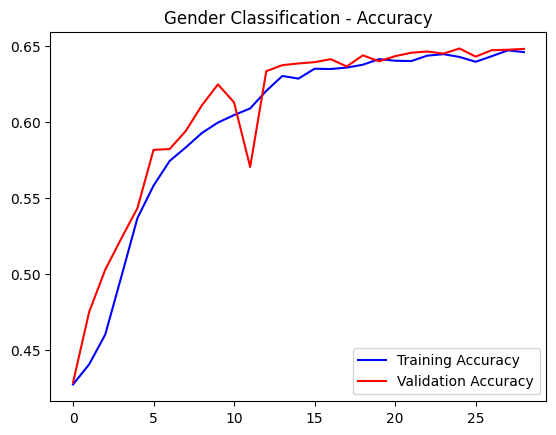

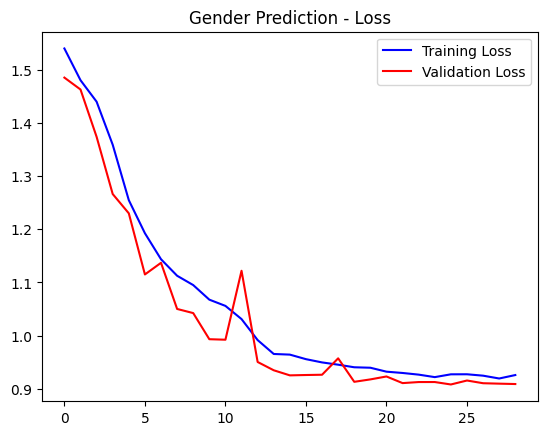

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Gender Classification - Accuracy')
plt.legend()
plt.figure()


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Gender Prediction - Loss')
plt.legend()
plt.show()

112/112 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

       Adult       0.42      0.11      0.17       585
       Child       0.88      0.88      0.88       488
     Elderly       0.59      0.26      0.36       153
      Senior       0.52      0.70      0.60       574
    Teenager       0.00      0.00      0.00       232
 Young Adult       0.66      0.90      0.76      1523

    accuracy                           0.65      3555
   macro avg       0.51      0.47      0.46      3555
weighted avg       0.58      0.65      0.59      3555



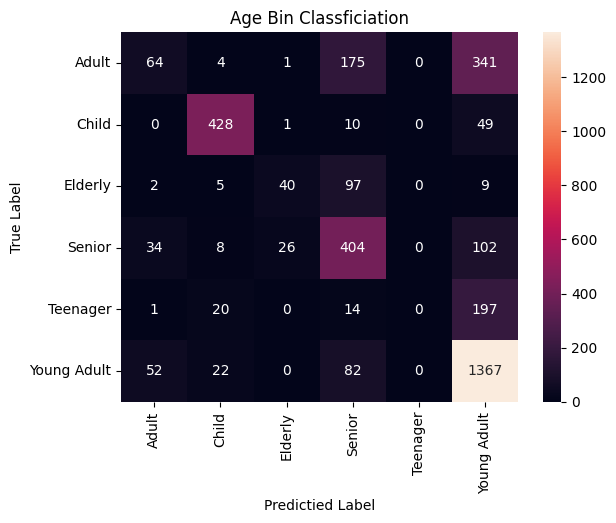

In [41]:
y_pred_age = age_model.predict(X_test)
pred_classes = np.argmax(y_pred_age,axis=1)

evaluate_classification_model(y_test_age_binned.values, pred_classes, list(encoder.classes_))

In [92]:
pred = test.sample()
predict_age(pred.values[0][0], pred.values[0][4], pred.values[0][3])

Actual age: 47
Actual age group: Adult
Predicted age group: Child


#### Oversample Data

In [29]:
age_model_over = Sequential([

    RandomFlip(mode = 'horizontal', seed = 27, input_shape = (input_shape)),
    RandomFlip(mode = 'vertical', seed = 27),
    RandomRotation(factor = 0.1, fill_mode='nearest', seed = 27),
    RandomContrast(factor = 0.1, seed = 27),

    # convolutional layers
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = (input_shape)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(512, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dropout(0.2),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dropout(0.5),

    Dense(num_classes, activation = 'softmax')

])
age_model_over.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
age_model_over.build(input_shape)
age_model_over.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 48, 48, 1)         0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 48, 48, 1)         0         
                                                                 
 random_rotation (RandomRot  (None, 48, 48, 1)         0         
 ation)                                                          
                                                                 
 random_contrast (RandomCon  (None, 48, 48, 1)         0         
 trast)                                                          
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0

In [31]:
# callbacks = [tensorboard_callback,
callbacks = [EarlyStopping(patience=4, monitor='val_loss', mode='min'),
             ReduceLROnPlateau(patience=2, verbose=1, monitor='val_accuracy')]

history_over = age_model_over.fit(X_train_over, y_train_over,
                        epochs=30,
                        batch_size=32,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test_age_binned))

Epoch 1/30
963/963 [==============================] - 20s 12ms/step - loss: 1.6975 - accuracy: 0.2805 - val_loss: 1.6437 - val_accuracy: 0.4293 - lr: 0.0010
Epoch 2/30
963/963 [==============================] - 11s 11ms/step - loss: 1.6234 - accuracy: 0.3201 - val_loss: 1.4916 - val_accuracy: 0.4658 - lr: 0.0010
Epoch 3/30
963/963 [==============================] - 11s 12ms/step - loss: 1.4558 - accuracy: 0.3940 - val_loss: 1.2708 - val_accuracy: 0.5443 - lr: 0.0010
Epoch 4/30
963/963 [==============================] - 11s 11ms/step - loss: 1.3466 - accuracy: 0.4359 - val_loss: 1.2909 - val_accuracy: 0.4824 - lr: 0.0010
Epoch 5/30
961/963 [============================>.] - ETA: 0s - loss: 1.2715 - accuracy: 0.4594
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
963/963 [==============================] - 11s 11ms/step - loss: 1.2713 - accuracy: 0.4594 - val_loss: 1.2105 - val_accuracy: 0.4323 - lr: 0.0010
Epoch 6/30
963/963 [==============================] -

In [32]:
age_model_over.save('/content/drive/MyDrive/comp4449_final/models/age/3')

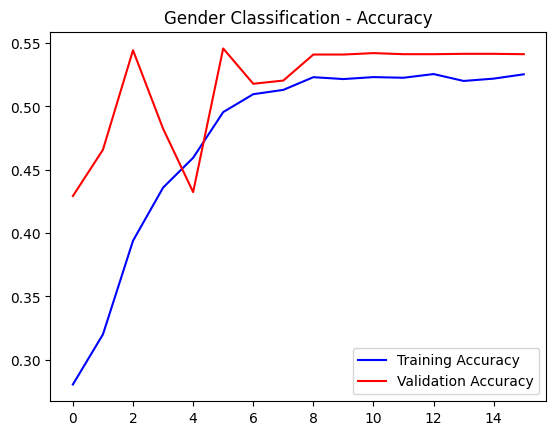

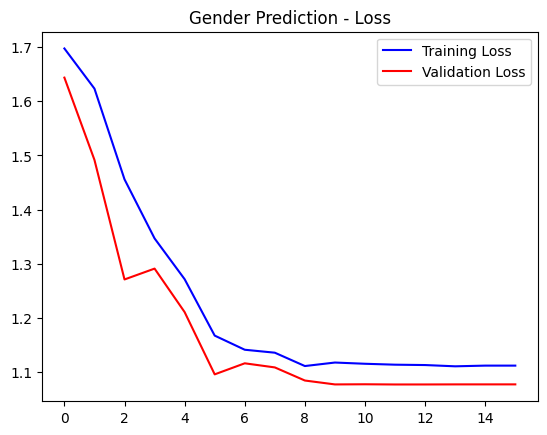

In [33]:
acc = history_over.history['accuracy']
val_acc = history_over.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Gender Classification - Accuracy')
plt.legend()
plt.figure()


loss = history_over.history['loss']
val_loss = history_over.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Gender Prediction - Loss')
plt.legend()
plt.show()

112/112 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

       Adult       0.34      0.43      0.38       585
       Child       0.91      0.78      0.84       488
     Elderly       0.26      0.80      0.39       153
      Senior       0.49      0.06      0.10       574
    Teenager       0.18      0.28      0.22       232
 Young Adult       0.71      0.70      0.71      1523

    accuracy                           0.54      3555
   macro avg       0.48      0.51      0.44      3555
weighted avg       0.59      0.54      0.53      3555



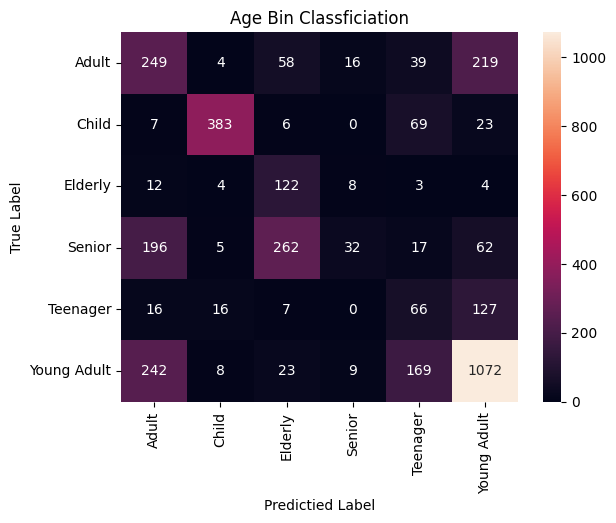

In [37]:
y_pred_age_over = age_model_over.predict(X_test)
pred_classes_over = np.argmax(y_pred_age_over,axis=1)

evaluate_classification_model(y_test_age_binned.values, pred_classes_over, list(encoder.classes_))

#### Undersampled Data

In [69]:
age_model_under = Sequential([

    RandomFlip(mode = 'horizontal', seed = 27, input_shape = (input_shape)),
    RandomFlip(mode = 'vertical', seed = 27),
    RandomRotation(factor = 0.1, fill_mode='nearest', seed = 27),
    RandomContrast(factor = 0.1, seed = 27),

    # convolutional layers
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = (input_shape)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    # Dense(256, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dropout(0.4),

    Dense(num_classes, activation = 'softmax')

])
age_model_under.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
age_model_under.build(input_shape)
age_model_under.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_12 (RandomFlip  (None, 48, 48, 1)         0         
 )                                                               
                                                                 
 random_flip_13 (RandomFlip  (None, 48, 48, 1)         0         
 )                                                               
                                                                 
 random_rotation_6 (RandomR  (None, 48, 48, 1)         0         
 otation)                                                        
                                                                 
 random_contrast_6 (RandomC  (None, 48, 48, 1)         0         
 ontrast)                                                        
                                                                 
 conv2d_34 (Conv2D)          (None, 46, 46, 32)       

In [70]:
history_under = age_model_under.fit(X_train_over, y_train_over,
                        epochs=30,
                        batch_size=32,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test_age_binned))

Epoch 1/30
963/963 [==============================] - 12s 9ms/step - loss: 1.6799 - accuracy: 0.2900 - val_loss: 1.5901 - val_accuracy: 0.4371 - lr: 0.0010
Epoch 2/30
963/963 [==============================] - 8s 9ms/step - loss: 1.4797 - accuracy: 0.3791 - val_loss: 1.2216 - val_accuracy: 0.5364 - lr: 0.0010
Epoch 3/30
963/963 [==============================] - 8s 9ms/step - loss: 1.3234 - accuracy: 0.4404 - val_loss: 1.1912 - val_accuracy: 0.5339 - lr: 0.0010
Epoch 4/30
962/963 [============================>.] - ETA: 0s - loss: 1.2397 - accuracy: 0.4714
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
963/963 [==============================] - 9s 9ms/step - loss: 1.2397 - accuracy: 0.4714 - val_loss: 1.2034 - val_accuracy: 0.5142 - lr: 0.0010
Epoch 5/30
963/963 [==============================] - 8s 9ms/step - loss: 1.1494 - accuracy: 0.5103 - val_loss: 1.0954 - val_accuracy: 0.5297 - lr: 1.0000e-04
Epoch 6/30
959/963 [============================>.] - ETA:

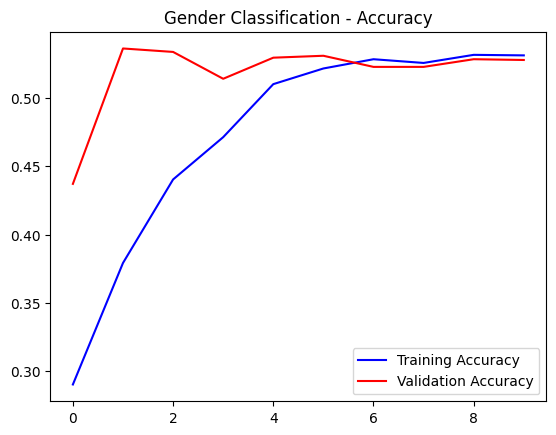

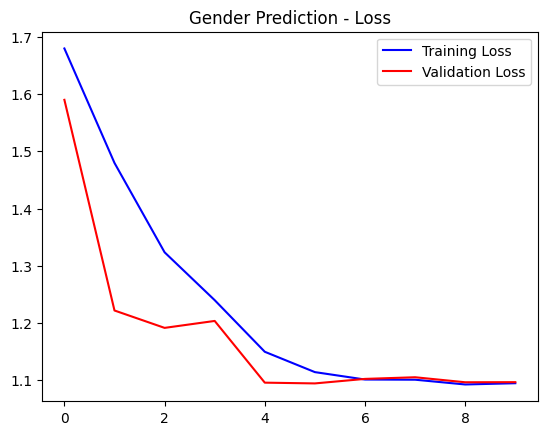

In [71]:
acc = history_under.history['accuracy']
val_acc = history_under.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Gender Classification - Accuracy')
plt.legend()
plt.figure()


loss = history_under.history['loss']
val_loss = history_under.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Gender Prediction - Loss')
plt.legend()
plt.show()

112/112 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       Adult       0.35      0.43      0.38       585
       Child       0.93      0.77      0.84       488
     Elderly       0.25      0.83      0.39       153
      Senior       0.53      0.05      0.10       574
    Teenager       0.19      0.39      0.25       232
 Young Adult       0.72      0.66      0.69      1523

    accuracy                           0.53      3555
   macro avg       0.49      0.52      0.44      3555
weighted avg       0.60      0.53      0.52      3555



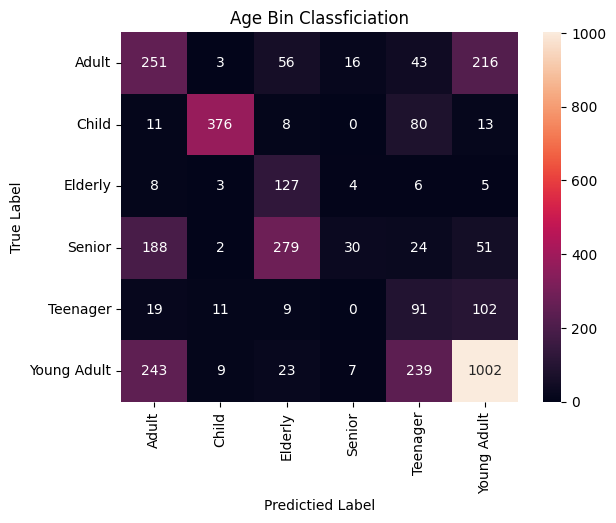

In [72]:
y_pred_age_under = age_model_under.predict(X_test)
pred_classes_under = np.argmax(y_pred_age_under,axis=1)

evaluate_classification_model(y_test_age_binned.values, pred_classes_under, list(encoder.classes_))